[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbamman/anlp25/blob/main/2.compare/ChiSquare_Mann_Whitney.ipynb)

# Comparing prevalence of terms

This notebook examines the words that distinguish the [2024 Democrat party platform](https://www.presidency.ucsb.edu/documents/2024-democratic-party-platform) from the [2024 Republican party platform](https://www.presidency.ucsb.edu/documents/2024-republican-party-platform) (both sourced from the American Presidency Project at UCSB), using the Chi-Square test and the Mann-Whitney test.

In [1]:
!wget --no-check-certificate https://raw.githubusercontent.com/dbamman/anlp25/main/data/2024_democrat_party_platform.txt
!wget --no-check-certificate https://raw.githubusercontent.com/dbamman/anlp25/main/data/2024_republican_party_platform.txt

--2025-09-04 22:42:22--  https://raw.githubusercontent.com/dbamman/anlp25/main/data/2024_democrat_party_platform.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283046 (276K) [text/plain]
Saving to: ‘2024_democrat_party_platform.txt’

2024_democrat_party 100%[===================>] 276.41K  1.49MB/s    in 0.2s    

2025-09-04 22:42:22 (1.49 MB/s) - ‘2024_democrat_party_platform.txt’ saved [283046/283046]

--2025-09-04 22:42:23--  https://raw.githubusercontent.com/dbamman/anlp25/main/data/2024_republican_party_platform.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request

In [2]:
import json
import math
import operator
import sys
from collections import Counter

import nltk
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
def read(filename):
    with open(filename, encoding="utf-8") as file:
        # lowercase text
        return file.read().lower()

In [4]:
democrat_text = read("2024_democrat_party_platform.txt")

In [5]:
republican_text = read("2024_republican_party_platform.txt")

Explore your assumptions between the words you think will most distinguish the Democrat and Republican platforms.  Before looking at the results of the tests, what words do you think will be comparatively distinct to both?  (If you're not familiar with either, scan the platforms linked above).

In [6]:
def tokenize(data):
    return nltk.word_tokenize(data)

In [7]:
def get_counts(tokens):
    counts = Counter()
    for token in tokens:
        counts[token] += 1
    return counts

## $\chi^2$ test

The $\chi^2$ test as used in the comparison of different texts is designed to measure how statistically significant the distribution of counts in a 2x2 contingency table is.  Use the following function to analyze the difference between the platforms.  How do the most distinct terms comport with your assumptions?

In [8]:
def get_contingency_table(word, word_counts_a, word_counts_b, total_count_a = None, total_count_b = None):
    """
    Construct a 2x2 contingency table that takes the form of:

      # word in A | # word in B
    --------------+--------------
     # total in A | # total in B
    """
    # we can take the total counts as input if they are precomputed
    # otherwise, we can also compute them easily by summing the word counts
    if total_count_a is None:
        total_count_a = sum(word_counts_a.values())
    if total_count_b is None:
        total_count_b = sum(word_counts_b.values())

    return np.array([
        [word_counts_a[word], word_counts_b[word]],
        [total_count_a - word_counts_a[word], total_count_b - word_counts_b[word]]
    ])

def chi_sq(o):
    """Calculate chi-square value for 2x2 contingency table o

    We use the simpler form given in Manning and Schuetze (1999)
    for 2x2 contingency tables:
    https://nlp.stanford.edu/fsnlp/promo/colloc.pdf, equation 5.7
    """

    N = o.sum()
    return (N * (o[0,0] * o[1,1] - o[0,1] * o[1,0]) ** 2) / ((o[0,0] + o[0,1]) * (o[0,0] + o[1,0]) * (o[0,1] + o[1,1]) * (o[1,0] + o[1,1]))

def run_chi_square_on_corpus(word_counts_a, word_counts_b):
    total_count_a = 0.0
    total_count_b = 0.0
    vocab = {}
    for word in word_counts_a:
        vocab[word] = 1
        total_count_a += word_counts_a[word]
    for word in word_counts_b:
        vocab[word] = 1
        total_count_b += word_counts_b[word]

    total_words = total_count_a + total_count_b

    chisq_vals = {}
    for word in vocab:
        contingency_table = get_contingency_table(
            word,
            word_counts_a,
            word_counts_b,
            total_count_a,
            total_count_b
        )

        chisq_vals[word] = chi_sq(contingency_table)

    sorted_chi = sorted(chisq_vals.items(), key=lambda x: x[1], reverse=True)
    corpus_a_words = []
    corpus_b_words = []

    for word, chisq_val in sorted_chi:
        if word_counts_a[word] / total_count_a > word_counts_b[word] / total_count_b:
            corpus_a_words.append(word)
        else:
            corpus_b_words.append(word)

    print("Democrat:\n")
    for word in corpus_a_words[:20]:
        print(f"{word}\t{chisq_vals[word]}")

    print("Republican:\n")
    for word in corpus_b_words[:20]:
        print(f"{word}\t{chisq_vals[word]}")

In [9]:
democrat_tokens = tokenize(democrat_text)
democrat_counts = get_counts(democrat_tokens)

In [10]:
republican_tokens = tokenize(republican_text)
republican_counts = get_counts(republican_tokens)

Before running chi-square on all the words, let's step through the calculation on a single word first. We begin by plotting the 2x2 contingency table of the occurrences of each word in each corpus. We normalize to get probabilities.

In [11]:
def plot_contingency_table(table, normalize=False):
    if normalize:
        table = table / table.sum(axis=0)


    fig, ax = plt.subplots()
    im = ax.imshow(table, aspect='auto')

    ax.set_xticks(range(table.shape[1]))
    ax.set_yticks(range(table.shape[0]))

    for i in range(table.shape[0]):
        for j in range(table.shape[1]):
            value = table.iloc[i, j] if hasattr(table, 'iloc') else table[i, j]
            text_color = 'white' if value < table.max() * 0.5 else 'black'

            if normalize:
                text = f'{value:.3f}'
            else:
                text = f'{int(value)}'

            ax.text(j, i, text, ha='center', va='center',
                   color=text_color, fontsize=12, fontweight='bold')

    title = "Contingency Table"
    x_label = "Corpus"
    y_label = "Present"
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
    ax.set_xticklabels(["Democrat", "Republican"])
    ax.set_yticklabels(["Yes", "No"])
    # Add grid
    ax.set_xticks(np.arange(table.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(table.shape[0]+1)-.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)

    plt.tight_layout()
    return ax


In [12]:
table = get_contingency_table("biden", democrat_counts, republican_counts)

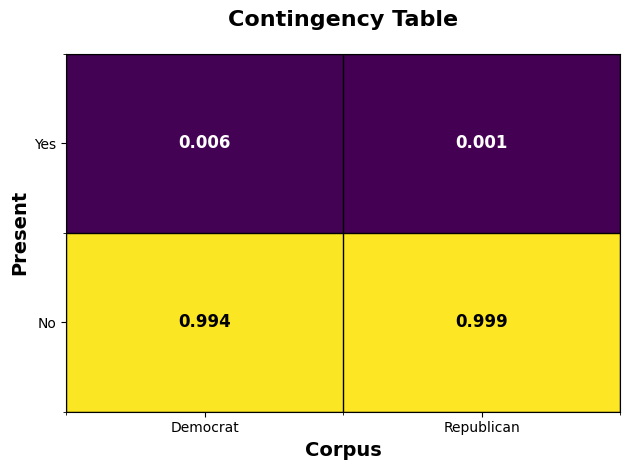

In [13]:
plot_contingency_table(table, normalize=True);

We can see that the Democrat platform mentions "biden" more, but is this statistically significant? We can use the chi-square test to test against the null hypothesis that the distribution of "biden" in the two platforms are equivalent.

For two categories, we can consult a [chi-square table](https://math.arizona.edu/~jwatkins/chi-square-table.pdf) to see that a value of $>7.879$ yields a statistically significant result at $\alpha = 0.005$.

In [14]:
chi_sq(table)

np.float64(21.957209570755417)

Now let's run the chi-square test on all the words in the vocabulary to see which ones are more prevalent in which platform.

In [15]:
run_chi_square_on_corpus(democrat_counts, republican_counts)

Democrat:

he	25.578937907602207
president	25.240684588166364
biden	21.957209570755417
health	20.629391568069238
has	18.46851899852054
;	17.350548213383796
more	16.24209281464817
to	14.720925762720206
–	13.06757521862527
democrats	12.75739755945743
his	11.894371467083399
also	10.896188152916178
administration	10.652501762817238
'll	10.299101170499748
$	10.293492985209557
million	9.921755986169687
communities	9.911181439317904
climate	9.795983533827304
're	9.292940096456055
's	9.092220881909837
Republican:

republicans	362.5062166239803
our	144.34125820348544
will	132.9429440298066
restore	123.66140922422055
american	121.36685794807758
sense	103.68547886176314
party	94.2393522889684
great	93.45494168709324
1.	87.73063575523085
2.	87.73063575523085
3.	87.73063575523085
4.	87.73063575523085
common	86.42988534079244
5.	79.753654870448
borders	70.69751070564378
illegal	70.57151364994098
!	63.80057435671095
republican	56.80659867119803
6.	55.824474695305135
stop	53.99989143674314


Are these results surprising? Examine specific words to check their frequency in both datasets.

In [16]:
print("Totals: R: %s, D: %s" % (len(republican_tokens), len(democrat_tokens)))

Totals: R: 6053, D: 48266


In [17]:
word = "climate"
print("%s -- R: %s, D: %s" % (word, republican_counts[word], democrat_counts[word]))

climate -- R: 0, D: 78


## Mann-Whitney

We saw earlier that $\chi^2$ is not a perfect estimator since doesn't account for the "burstiness" of language -- if we see the word "Dracula" in a text, we're probably going to see it again in that same text. The occurrence of words are not independent random events; they are tightly coupled with each other. If we're trying to understanding the robust differences between two corpora, we might prefer to prioritize words that show up more frequently everywhere in corpus A (but not in corpus B) over those that show up only very frequently within narrow slice of A (such as one text in a genre, one chapter in a book, or one speaker when measuring the differences between policital parties). Use the following function to execute the Mann-Whitney test to account for this phenomenon while finding distinctive terms.

In [18]:
def count_differences(tokens_a, tokens_b):
    """Measure the difference in the frequency of each word between two corpora."""
    total_len_a = len(tokens_a)
    total_len_b = len(tokens_b)

    word_counts_a = Counter(tokens_a)
    word_counts_b = Counter(tokens_b)

    vocab = set(word_counts_a) | set(word_counts_b)

    differences = {}
    for word in vocab:
        freq_a = word_counts_a[word] / total_len_a
        freq_b = word_counts_b[word] / total_len_b
        diff = freq_a - freq_b
        differences[word] = diff

    return differences


def get_chunk_counts(tokens, chunk_size):
    """Get token counts for chunks of the corpus.

    Returns a list of Counters, each with token counts for their respective chunk.
    """
    chunks = []
    for i in range(0, len(tokens), chunk_size):
        counts = Counter()
        for j in range(chunk_size):
            if i + j < len(tokens):
                counts[tokens[i + j]] += 1
        chunks.append(counts)
    return chunks


def mann_whitney(tokens_a, tokens_b):
    chunk_size = 500
    chunks_a = get_chunk_counts(tokens_a, chunk_size)
    chunks_b = get_chunk_counts(tokens_b, chunk_size)

    pvals = {}
    vocab = set(tokens_a + tokens_b)
    for word in vocab:
        a = []
        b = []

        # Note a and b can be different lengths (i.e., different sample sizes)
        #
        # See Mann and Whitney (1947), "On a Test of Whether one of Two Random
        # Variables is Stochastically Larger than the Other"
        # https://projecteuclid.org/download/pdf_1/euclid.aoms/1177730491

        # (This is part of their innovation over the case of equal sample sizes in Wilcoxon 1945)

        for chunk in chunks_a:
            a.append(chunk[word])
        for chunk in chunks_b:
            b.append(chunk[word])

        # Consider: what information do `a` and `b` encode?

        # we use the scipy implementation of the Mann-Whitney U rank test
        # see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
        statistic, pval = mannwhitneyu(a, b, alternative="two-sided")

        # We'll use the p-value as our quantity of interest.  [Note in the normal appproximation
        # that Mann-Whitney uses to assess significance for large sample sizes, the significance
        # of the raw statistic depends on the number of ties in the data, so the statistic itself
        # isn't exactly comparable across different words]
        pvals[word] = pval

    return pvals


def mann_whitney_analysis(tokens_a, tokens_b):

    pvals = mann_whitney(tokens_a, tokens_b)

    # Mann-Whitney tells us the significance of a term's difference in two groups, but we also
    # need the directionality of that difference (whether it's used more by group A or group B.

    # Let's use our difference-in-proportions function above to check the directionality.
    # [Note we could also measure directionality by checking whether the Mann-Whitney statistic
    # is greater or less than the mean=len(one_chunks)*len(two_chunks)*0.5.]

    differences = count_differences(tokens_a, tokens_b)

    terms_a = {k : pvals[k] for k in pvals if differences[k] <= 0}
    terms_b = {k : pvals[k] for k in pvals if differences[k] > 0}

    sorted_pvals = sorted(terms_a.items(), key=lambda x: x[1])
    print("More Republican:\n")
    for k,v in sorted_pvals[:20]:
        print("%s\t%.15f" % (k,v))

    print("\nMore Democrat:\n")
    sorted_pvals = sorted(terms_b.items(), key=operator.itemgetter(1))
    for k,v in sorted_pvals[:25]:
        print("%s\t%.15f" % (k,v))

In [19]:
mann_whitney_analysis(democrat_tokens, republican_tokens)

More Republican:

3.	0.000000000000000
2.	0.000000000000000
4.	0.000000000000000
5.	0.000000000000002
1.	0.000000000000002
party	0.000000000000038
6.	0.000000000000114
sense	0.000000000008190
common	0.000000000144498
7.	0.000000000528410
!	0.000000000534225
defend	0.000000017446747
borders	0.000000022951439
restore	0.000000031100963
radical	0.000000032959074
migrant	0.000000033003564
republican	0.000000046730387
offer	0.000000092697227
great	0.000000127801343
foreign	0.000000230012201

More Democrat:

has	0.000021982540537
biden	0.000022788005994
president	0.000026908311868
more	0.000087246628506
;	0.000129165227037
he	0.000135614740502
administration	0.000546785654793
his	0.000651393384907
also	0.001048131366703
–	0.001138187086232
health	0.001163384894353
to	0.001367427651009
's	0.001680150044372
democrats	0.002018344719265
is	0.003060608048870
million	0.003655707966951
for	0.004348220401109
communities	0.004826808497881
across	0.007078041735568
continue	0.008414709453209
percent	0.0